# Workation Price Prediction Challenge
---------------------------------------

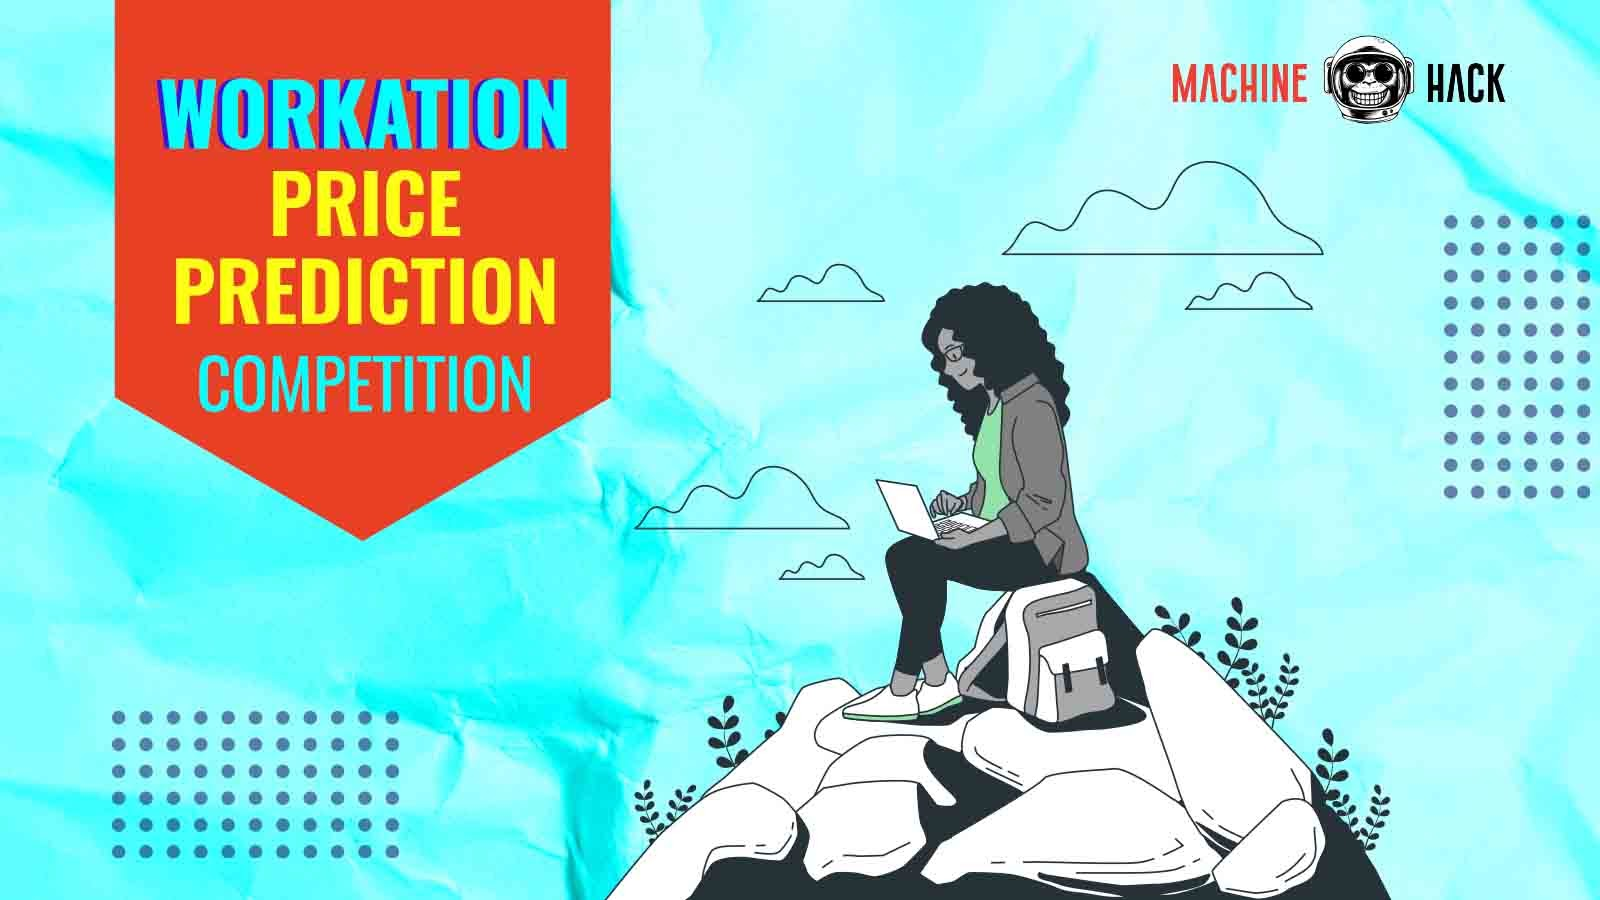

The new covid-era has provided a new way of living the work-life balance. We have seen a lot of different websites providing packages to work from different locations. From Kashmir to Kanyakumari, from Gujarat to Assam we have collected packages in and around India. It becomes really difficult to find the best place with all the amenities such as high-speed internet, a comfortable stay as well as within the budget. To solve the real-world problem of finding the best deals for a calm and enjoying workation trip. Workation is the best way to work at a remote location with a recreational and rejuvenating vacation for the team.

In this competition, one has to use the knowledge of machine learning, deep learning, and model building to predict the price per person for your next workstation trip. The data has more than 18000+ rows of different packages with the details like start location, hotel type, cost per person, destination, Itinerary, and many more.

**Dataset Description:**

- Train.csv - 21000 rows x 15 columns (Includes Per Person Price Column as Target variable)
- Test.csv - 9000 rows x 14 columns (Doesn't include the Target Variable)
- Sample Submission.csv - Please check the Evaluation section for more details on how to generate a valid submission

**Attributes:**

- **Uniq Id** - Unique Identifier per row sample
- **Package Name** - Name of the tour package
- **Package Type** - Type of the tour package
- **Destination** - A destination place
- **Itinerary** - complete itinerary
- **Places Covered** - covered places in the itinerary
- **Travel Date** - Date of travel
- **Hotel Details** - Details of the hotel stay
- **Start City** - Start place for the travel
- **Airline** - Flight details
- **Flight Stops** - Intermediate stops if any
- **Meals** - Inflight meals or services
- **Sightseeing Places Covered** - Itinerary details regarding sightseeing
- **Cancellation Rules** - Cancellation policy as per travel company
- **Per Person Price** - Price of the tour package per person (Target Column)


**Skills:**

- Advanced Regression Modeling
- Feature Engineering, Ensemble Modeling
- Optimizing RMSLE(Root Mean Squared Log Error) as a metric to generalize well on unseen data

In [ ]:
# from distributed import Client
# client = Client(n_workers=6)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
data = pd.read_csv('../input/workation-price-prediction-challengemachinehack/Train.csv', parse_dates=['Travel Date'])
data.info()

In [ ]:
data.head()

In [ ]:
def split_category(value):
    vals = []
    if '|' in value:
        vals = value.split('|')
    else:
        vals.append(value)
    return vals

def show_category(series):
    values = {}
    for val in series:
        for each in val:
            if each in values:
                values[each] += 1
            else:
                values[each] = 1
    return values

In [ ]:
data['Airline'] = data['Airline'].apply(split_category)
data['Destination'] = data.Destination.apply(split_category)
data['Places Covered'] = data['Places Covered'].apply(split_category)
data['Sightseeing Places Covered'] = data['Sightseeing Places Covered'].apply(split_category)

In [ ]:
plt.figure(figsize=(19, 6))
plt.plot(data['Per Person Price'])
plt.show()

In [ ]:
data.head()

## Feature Engineering

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
# One hot Encoding the "Package Type" column
dummy_type = pd.get_dummies(data['Package Type'], prefix='type')
data.drop(columns=['Package Type'], inplace=True)
data = pd.concat([data, dummy_type], axis=1)

# # Label Encoding of the "Start City" Column
# label_encoder1 = LabelEncoder().fit(data['Start City'])
# data['Start City'] = label_encoder1.transform(data['Start City'])

# One hot Encoding the "Start City" column
dummy_city = pd.get_dummies(data['Start City'], prefix='sc')
data.drop(columns=['Start City'], inplace=True)
data = pd.concat([data, dummy_city], axis=1)

# Label Encoding of the "Cancellation Rules" Column
label_encoder2 = LabelEncoder().fit(data['Cancellation Rules'])
data['Cancellation Rules'] = label_encoder2.transform(data['Cancellation Rules'])

In [ ]:
def make_feature_col(series, all_keys):
    feature_dict = {}
    for key in all_keys:
        feature_dict[key] = []

    for items in series:
        for key in all_keys:
            if key not in items:
                feature_dict[key].append(0)
            else:
                feature_dict[key].append(1)

    return pd.DataFrame(feature_dict)

In [ ]:
# Structuring "Airline" Column
A_all_keys = show_category(data['Airline']).keys()
airline = make_feature_col(data['Airline'], A_all_keys)
data = pd.concat([data, airline], axis=1)

# Structuring "Destination" Column
D_all_keys = show_category(data['Destination']).keys()
destination = make_feature_col(data['Destination'], D_all_keys)
data = pd.concat([data, destination], axis=1)

# Structuring "Places Covered" Column
change = lambda pc: [each+'_pc' for each in pc]
PC_all_keys = show_category(data['Places Covered']).keys()
PC_all_keys = change(PC_all_keys)

p_covered = make_feature_col(data['Places Covered'], PC_all_keys)
data = pd.concat([data, p_covered], axis=1)

In [ ]:
features = ['Flight Stops', 'Meals', 'Cancellation Rules']
other_features = data.columns[14:].to_list()
features.extend(other_features)
target = ['Per Person Price']

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('Shape of train set:', X_train.shape)
print('Shape of test set:', X_test.shape)

## Model Building

- Approach 1
    - Features: `'Start City', 'Flight Stops', 'Meals', 'Cancellation Rules'`+ data.columns\[14:\].to_list()
    (`Package Type` and `Airline` columns are converted into single column same as One-Hot encoding.)

        - RMSLE: 0.3999, Algorithm: XGBRegressor
        - RMSLE: 0.4138, Algorithm: RandomForestRegressor
        - RMSLE: 0.4144, Algorithm: BaggingRegressor
        - RMSLE: 0.4197, Algorithm: ExtraTreesRegressor

- Approach 2
    - Features: `'Start City', 'Flight Stops', 'Meals', 'Cancellation Rules'`+ data.columns\[14:\].to_list()
    (`Package Type`, `Airline` and `Destination` columns are converted into single column same as One-Hot encoding.)
        
        - RMSLE: 0.2424, Algorithm: XGBRegressor
        - RMSLE: 0.2486, Algorithm: RandomForestRegressor
        - RMSLE: 0.2566, Algorithm: BaggingRegressor
        - RMSLE: 0.2749, Algorithm: ExtraTreesRegressor
        - RMSLE: 0.2305, Algorithm: CatBoostRegressor(iterations=100000, depth=2, learning_rate=0.1, loss_function='MAE')

- Approach 2
    - Features: `'Start City', 'Flight Stops', 'Meals', 'Cancellation Rules'`+ data.columns\[14:\].to_list()
    (`Package Type`, `Airline`, `Destination` and `Places Covered` columns are converted into single column same as One-Hot encoding.)

        - RMSLE: 0.2398, Algorithm: XGBRegressor

In [ ]:
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor, BaggingRegressor, GradientBoostingRegressor
from catboost import Pool, CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# # specify the training parameters 
# model = CatBoostRegressor(iterations=100000, 
#                           depth=2, 
#                           learning_rate=0.3, 
#                           loss_function='MAE')
# #train the model
# model.fit(np.array(X_train), y_train.values)
# # make the prediction using the resulting model
# y_pred = model.predict(np.array(X_test))

In [ ]:
regressor = XGBRegressor()
regressor.fit(X_train, y_train.values.ravel())
y_pred = regressor.predict(X_test)

In [ ]:
print('RMSLE is {}'.format(np.sqrt(mean_squared_log_error(y_test, y_pred))))

In [ ]:
# from sklearn.model_selection import KFold, RepeatedKFold
# kf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=0)
# train_score = []
# test_score = []
# for train_index, test_index in kf.split(X):
#     # print("Train:", train_index, "Validation:", test_index)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     test_score.append(np.sqrt(mean_squared_log_error(y_test, regressor.predict(X_test))))
#     # train_score.append(np.sqrt(mean_squared_log_error(y_test, model.predict(X_train))))

# print('Test Score:', test_score)

In [ ]:
# sum(test_score)/len(test_score)

## Test Data Prediction

In [ ]:
test = pd.read_csv('../input/workation-price-prediction-challengemachinehack/Test.csv', parse_dates=['Travel Date'])
test.info()

In [ ]:
test['Airline'] = test['Airline'].apply(split_category)
test['Destination'] = test.Destination.apply(split_category)
test['Places Covered'] = test['Places Covered'].apply(split_category)
test['Sightseeing Places Covered'] = test['Sightseeing Places Covered'].apply(split_category)

In [ ]:
test.head()

In [ ]:
# One hot Encoding the "Package Type" column
dummy_type = pd.get_dummies(test['Package Type'], prefix='type')
test.drop(columns=['Package Type'], inplace=True)
test = pd.concat([test, dummy_type], axis=1)

# One hot Encoding the "Start City" column
dummy_city = pd.get_dummies(test['Start City'], prefix='sc')
test.drop(columns=['Start City'], inplace=True)
test = pd.concat([test, dummy_city], axis=1)

# Label Encoding of the "Cancellation Rules" Column
test['Cancellation Rules'] = label_encoder2.transform(test['Cancellation Rules'])

# Structuring "Airline" Column
airline = make_feature_col(test['Airline'], A_all_keys)
test = pd.concat([test, airline], axis=1)

# Structuring "Destination" Column
destination = make_feature_col(test['Destination'], D_all_keys)
test = pd.concat([test, destination], axis=1)

# Structuring "Places Covered" Column
p_covered = make_feature_col(test['Places Covered'], PC_all_keys)
test = pd.concat([test, p_covered], axis=1)

# "Travel Date" Column
test['month'] = test['Travel Date'].dt.month
test['day'] = test['Travel Date'].dt.month

In [ ]:
prediction = regressor.predict(test[features])
submission = pd.DataFrame(prediction, columns=target)

In [ ]:
# submission.to_csv('submissions/submit3.csv', index_label=False)